In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dir = "/content/drive/MyDrive/SafeReels-664/Extracted_Features"

In [4]:
X = []

In [5]:
for file in os.listdir(dir):
    if file.endswith(".npy"):
        file_path = os.path.join(dir, file)
        features = np.load(file_path)
        X.append(features)

In [6]:
X = np.array(X, dtype=np.float32)

In [7]:
X.shape

(664, 21160)

In [8]:
import pandas as pd
df = pd.read_csv("/content/Safereels annotation - Text_Annotation_data.csv")
df

,reel_id,isSafe,UnsafeType,Visual texts,Audio texts
0,www.facebook.com/reel/1000188341415358,1,Safe,Me on my way to watch Oppenheimer After Berbie,NaN
1,www.facebook.com/reel/1006146964533997,1,Safe,NaN,এ মামা দুইটা সিঙ্গারা আর দুইটা সমুচা একটু তাড়া...
2,www.facebook.com/reel/1007123741459823,0,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love,পাগলা হাওয়ার বাদল দিনে পাগল আমার মন জেগে ওঠে প...
3,www.facebook.com/reel/1007420607202244,1,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop,যুদ্ধ আনে ধ্বংস সজনী সজনী তোমারে দেখিয়া মাতাল ...
4,www.facebook.com/reel/1008519870870927,1,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং,NaN
...,...,...,...,...,...
659,www.facebook.com/reel/997262608752854,0,Adult,NaN,NaN
660,www.facebook.com/reel/997300345735398,0,Harmful,NaN,NaN
661,www.facebook.com/reel/998187401354206,1,Safe,খবরঃ কয়লা নিয়ে মোংলা বন্দরে এলো চীনের জাহাজ দে...,NaN
662,www.facebook.com/reel/999558344609179,1,Safe,সাকিব আল হাসান to বাংলাদেশী ক্রিকেট ফ্যান,NaN


In [9]:
df['UnsafeType'], uniques = pd.factorize(df['UnsafeType'])
uniques

Index(['Safe', 'Adult', 'Harmful', 'Suicidal'], dtype='object')

In [10]:
y = df['UnsafeType'].tolist()

In [11]:
y = np.array(y)
y.shape

(664,)

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

In [15]:
def extract_yamnet_embeddings(features):
    features = tf.convert_to_tensor(features, dtype=tf.float32)
    embeddings, _, _ = yamnet_model(features)
    return embeddings.numpy()

In [16]:
X_train_emb = np.array([extract_yamnet_embeddings(x) for x in X_train])
X_test_emb = np.array([extract_yamnet_embeddings(x) for x in X_test])

In [17]:
X_train_emb = X_train_emb.reshape(X_train_emb.shape[0], -1)
X_test_emb = X_test_emb.reshape(X_test_emb.shape[0], -1)

In [18]:
classifier = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train_emb.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(4, activation="softmax")  # 4-class classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
classifier.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

In [20]:
classifier.fit(X_train_emb, y_train, epochs=15, batch_size=16, validation_data=(X_test_emb, y_test))

Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.3543 - loss: 1.3683 - val_accuracy: 0.6241 - val_loss: 1.2556
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6272 - loss: 1.1952 - val_accuracy: 0.6241 - val_loss: 1.0434
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6101 - loss: 1.0386 - val_accuracy: 0.6241 - val_loss: 0.9501
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6292 - loss: 0.9352 - val_accuracy: 0.6241 - val_loss: 0.9303
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6188 - loss: 0.9222 - val_accuracy: 0.6241 - val_loss: 0.9222
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6304 - loss: 0.8928 - val_accuracy: 0.6241 - val_loss: 0.9196
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6210 - loss: 0.9249 - val_accuracy: 0.6241 - val_loss: 0.9182
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6092 - loss: 0.9032 - val_accuracy: 0.6241 - val_loss

In [24]:
y_pred = classifier.predict(X_test_emb)
y_pred_classes = np.argmax(y_pred, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [22]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77        83
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         1

    accuracy                           0.62       133
   macro avg       0.16      0.25      0.19       133
weighted avg       0.39      0.62      0.48       133



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


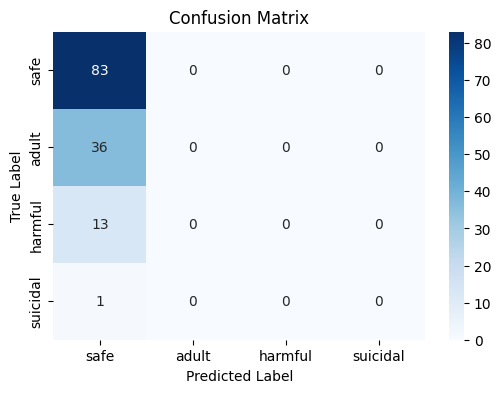

In [23]:
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["safe","adult","harmful","suicidal"], yticklabels=["safe","adult","harmful","suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()